In [4]:
import cv2
import os
import json
import sys

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

sys.path.append('..')
import data
import model
import preprocessing
import utils

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
params = utils.yaml_to_dict('../config.yml')
params['data_dir'] = os.path.join('..', params['data_dir'])
params['model_dir'] = os.path.join('..', params['model_dir'])
params['batch_size'] = 10

In [6]:
preprocessing.split_data(params)

In [7]:
def make_predictions(params, generator):
    
    base_model = tf.keras.applications.MobileNet(input_shape=params['image_shape'],include_top=False,weights='imagenet')
    base_model.trainable = False

    mobilnet_tiny = model.MobilNet_Architecture_Tiny(
        width_multiplier=params['width_multiplier'],
        depth_multiplier=params['depth_multiplier'],
        num_classes=params['num_classes'],
        dropout_rate=params['dropout_rate'],
        regularization_rate=params['regularization_rate'])

    net = tf.keras.Sequential([
        base_model,
        mobilnet_tiny])

    optimizer = tf.keras.optimizers.Adam(lr=params['learning_rate'])

    net.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    
    net.load_weights(os.path.join(params['model_dir'], 'tf_ckpt'))
        
    predict = net.predict(x=generator, batch_size=params['batch_size'], verbose=1)
    
    return np.argmax(predict,axis=1)

In [8]:
def plot_results(data_to_predict,predictions, mode, params):
    
    id_label_map = utils.load_id_label_map(params)
    
    fig, axis = plt.subplots(5,4, figsize=(20,20))
    
    images = data_to_predict[0]
    label = data_to_predict[1]
    
    k = 0
    for i in range(5):
        for j in range(2):

            if mode != 'test':
                title = id_label_map[label[k]]
            else:
                title = ''
                
            axis[i][(2*j)].imshow(images[k])
            axis[i][(2*j)].set_title(title)
            axis[i][(2*j)].axis('off')
            
            pred = id_label_map[predictions[k]]
            axis[i][(2*j)+1].text(0.5, 0.5, pred, size=25, ha="center", va="center",
                    bbox=dict(
                        boxstyle="round",
                        ec=(1., 0.5, 0.5),
                        fc=(1., 0.8, 0.8),
                    )
                   )
            axis[i][(2*j)+1].set_title('Prediction')
            axis[i][(2*j)+1].axis('off')
            
            k += 1
    plt.show()

# Predictions and Metrics in Training and Validation set

In [9]:
history_path = os.path.join(params['model_dir'], 'history.json')
with open(history_path, 'r') as file:
    history = json.load(file) 

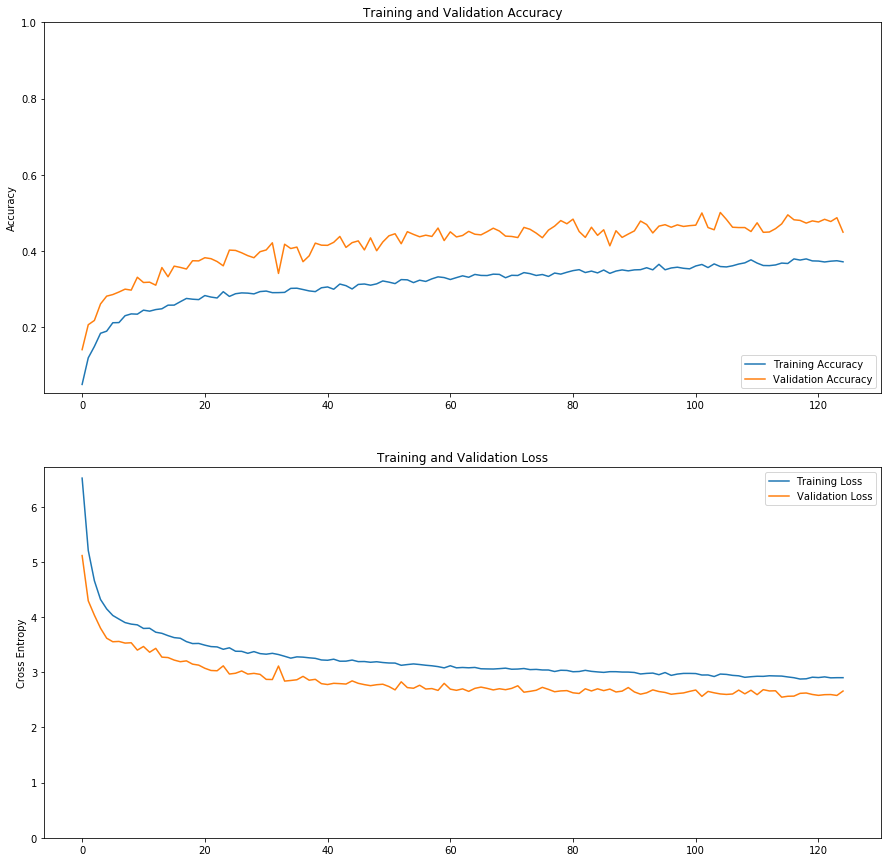

In [10]:
acc = history['acc']
val_acc = history['val_acc']

loss = history['loss']
val_loss = history['val_loss']

plt.figure(figsize=(15,15))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

## Training Results

Found 9600 images.
10/10 [==============================] - 1s 69ms/step


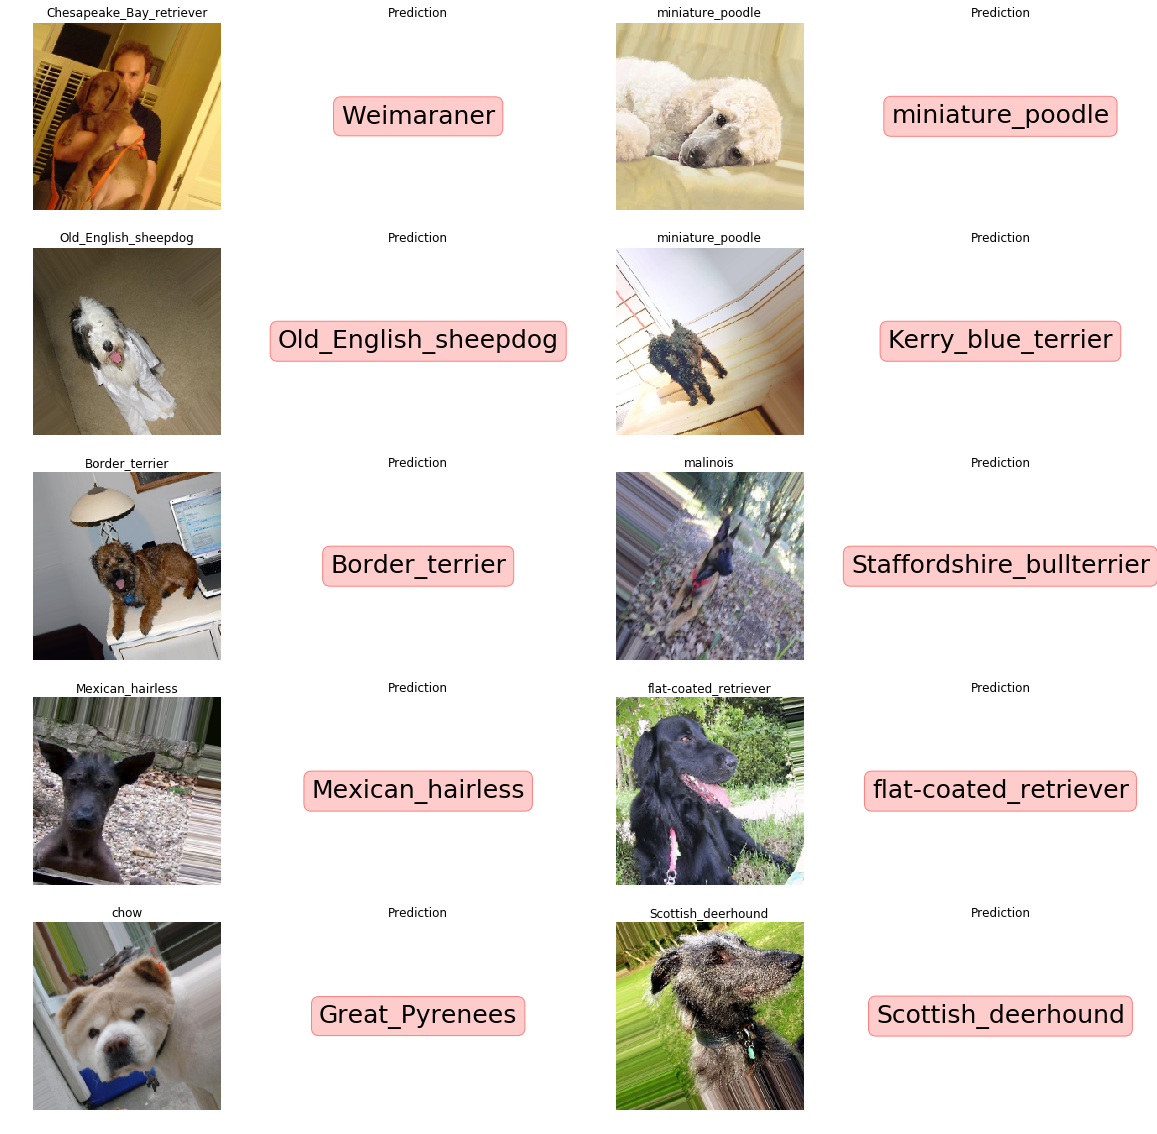

In [12]:
train_generator = data.data_generator(params, 'training')

data_to_predict = next(train_generator)
predictions = make_predictions(params, data_to_predict[0])

plot_results(data_to_predict,predictions, 'training', params)

## Validation Results

Found 2400 images.
10/10 [==============================] - 1s 111ms/step


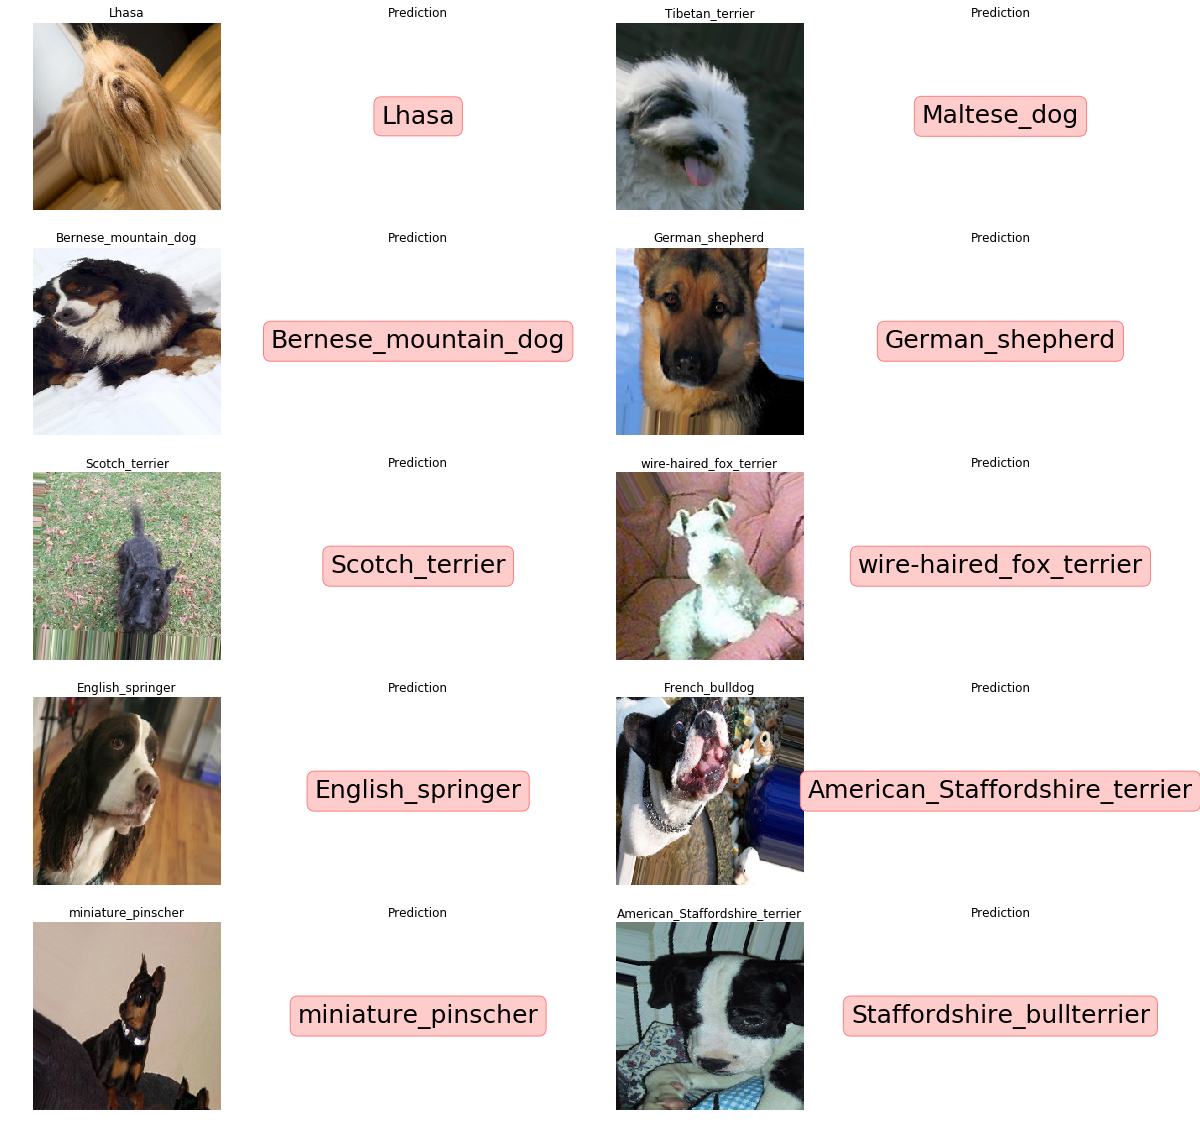

In [14]:
val_generator = data.data_generator(params, 'validation')

data_to_predict = next(val_generator)
predictions = make_predictions(params, data_to_predict[0])

plot_results(data_to_predict,predictions, 'validation', params)

# Predictions in Test Set

Found 8580 images.
10/10 [==============================] - 1s 135ms/step


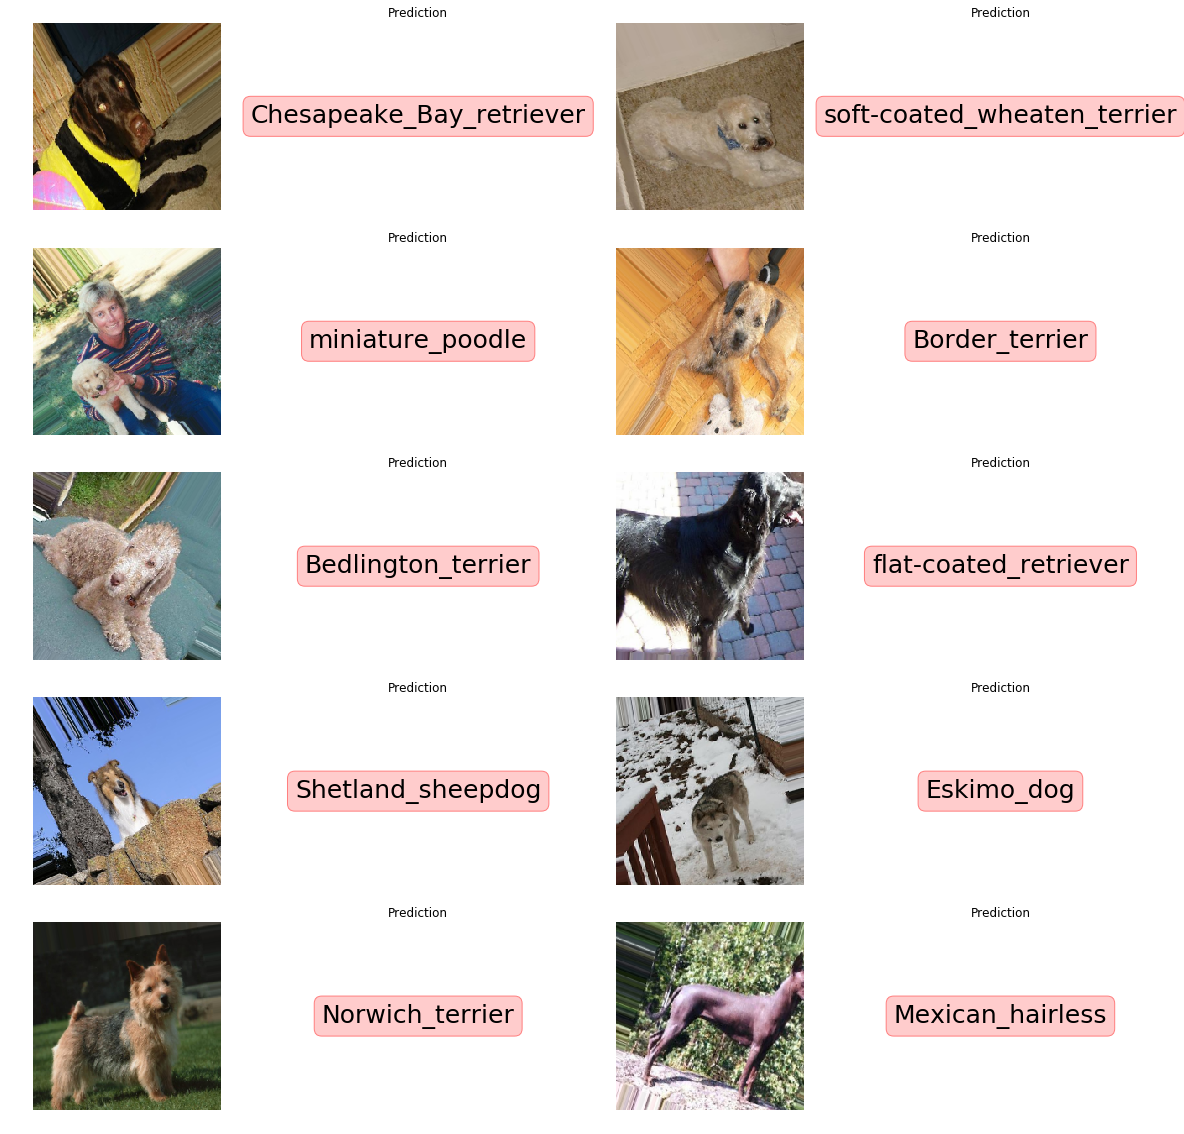

In [15]:
test_generator = data.data_generator(params, 'test')

data_to_predict = next(test_generator)
predictions = make_predictions(params, data_to_predict[0])

plot_results(data_to_predict,predictions, 'test', params)